# Freqbot

Python 3 web app for extracting frequency and other info from images.

Running here https://kwinkunks.pythonanywhere.com

App is here https://www.pythonanywhere.com/user/kwinkunks/files/home/kwinkunks/freqbot/flask_app.py?edit

In [10]:
import numpy as np
import scipy.stats, scipy.signal
from PIL import ImageStat
from matplotlib.pylab import find

def is_greyscale(im):
    """
    Decides if an imae is greyscale.
    """
    stat = ImageStat.Stat(im)
    if sum(stat.sum[:3])/3 == stat.sum[0]:
        return True
    return False

def parabolic(f, x):
    """
    Interpolation.
    """
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

def freq_from_crossings(sig, fs):
    """
    Frequency from zero crossings.
    """
    indices = find((sig[1:] >= 0) & (sig[:-1] < 0))
    crossings = [i - sig[i] / (sig[i+1] - sig[i]) for i in indices]
    return fs / np.mean(np.diff(crossings))

def freq_from_autocorr(sig, fs):
    """
    Frequency from autocorrelation.
    """
    sig = sig + 128
    corr = scipy.signal.fftconvolve(sig, sig[::-1], mode='full')
    corr = corr[len(corr)/2:]
    d = np.diff(corr)
    start = find(d > 0)[0]
    peak = np.argmax(corr[start:]) + start
    px, py = parabolic(corr, peak)
    return fs / px

def get_spectrum(signal, fs):
    """
    Computes the spectrum. Returns frequencies, coefficients,
    f_min and f_max.
    """
    windowed = signal * scipy.signal.blackmanharris(len(signal))
    a = abs(np.fft.rfft(windowed))
    f = np.fft.rfftfreq(len(signal), 1/fs)

    db = 20 * np.log10(a)
    sig = db - np.amax(db) + 20
    indices = find((sig[1:] >= 0) & (sig[:-1] < 0))
    crossings = [z - sig[z] / (sig[z+1] - sig[z]) for z in indices]
    mi, ma = np.amin(crossings), np.amax(crossings)
    x = np.arange(0, len(f))  # for back-interpolation
    f_min = np.interp(mi, x, f)
    f_max = np.interp(ma, x, f)
    return f, a, f_min, f_max

def freq_from_fft(signal, fs):
    """
    Peak frequency from FFT.
    """
    f, a, f_min, f_max = get_spectrum(signal, fs)
    i = np.argmax(a)
    true_i = parabolic(np.log(a), i)[0]
    return fs * true_i / len(signal)

def get_snr(i):
    """
    Bad algorithm
    """
    i += 128
    return np.nanmean(i) / np.nanstd(i)

def get_phase(i):
    """
    Computes phase using method from Purves's tutorial in TLE.
    """
    e = scipy.signal.hilbert(i)

    # Get the biggest 25 sample indices and sort them by amplitude
    biggest = np.argpartition(e.real, -25)[-25:]
    s = np.vstack((biggest, e.real[biggest])).T
    sort = s[s[:,1].argsort()][::-1]

    # Prune the list down to the biggest for realz
    biggest_pruned = [sort[:,0][0]]
    for ix in sort[:,0][1:]:
        add = True
        for got in biggest_pruned:
            if abs(ix - got) < 5:  # made-up number
                add = False
        if add:
            biggest_pruned.append(ix)
            if len(biggest_pruned) == 5: break

    # Get the interpolated phase values
    results = []
    for ix in biggest_pruned:
        true_i = parabolic(np.log(abs(e)+0.01), ix)[0]
        x = np.arange(0, len(e))
        rad = np.interp(true_i, x, np.angle(e))
        results.append(np.degrees(rad))

    return np.nanmean(results)

def get_trace_indices(y, ntraces, spacing):
    """
    Returns the indices of the traces to analyse.
    """
    if spacing == 'random':
        x = 0.05 + 0.9*np.random.random(ntraces)  # avoids edges
        ti = np.sort(x * y)
    else:
        n = ntraces + 1
        ti = np.arange(1./n,1.,1./n) * y
    return np.round(ti).astype(int)

def analyse(i, t_min, t_max, trace_indices, func):
    """
    Does everything.
    """
    fs = i.shape[0] / (t_max - t_min)

    spec, freq, phase, snr = [], [], [], []
    mis, mas = [], []
    for ti in trace_indices:
        trace = i[:, ti]
        try:
            f = func(trace, fs)
            freq.append(f)

            p = get_phase(trace)
            phase.append(p)
            
            snr.append(get_snr(trace))

            frq, amp, fmi, fma = get_spectrum(trace, fs)
            spec.append(amp)
            mis.append(fmi)
            mas.append(fma)

        except Exception:
            continue

    return spec, freq, phase, snr, mis, mas

Need to replace `find`...

In [3]:
sig = np.array([1, 2, 3, 2, 1, 0, -1, -2, -1, 1, 3, 1, -1, -3, 1, 2])
i1 = ((sig[1:] >= 0) & (sig[:-1] < 0)).nonzero()
i2 = find((sig[1:] >= 0) & (sig[:-1] < 0))

In [4]:
a = np.array([0,0,0,1,2,4,23,1,0,0,0,1])
find(a > 0)[0] == (a > 0).nonzero()[0][0]


True

## Parameters

In [12]:
# url = "https://math.berkeley.edu/~sethian/2006/Applications/Seismic/time_mig_img.jpg"
url = "http://www.spectrumgeo.com/wp-content/uploads/BPC-Bahamas-Data-Example.jpg"

method = 'xing'
avg = 'mean'
region = None
# region = '199,141,1608,1087'
ntraces = 10
trace_spacing = 'random' or 'regular'
spectrum = 'none'
bins = 9
t_min = 0
t_max = 3.4


## Main calculations

In [13]:
from PIL import Image
from io import BytesIO
import uuid
import requests

uuid_str = str(uuid.uuid1())

# Constants
methods = {'auto': freq_from_autocorr,
       'fft':  freq_from_fft,
       'xing': freq_from_crossings
       }

# Sanitize
ntraces = int(ntraces)
bins = float(bins)
t_min = float(t_min)
t_max = float(t_max)

if spectrum.lower() == ('none' or 'false' or 'no'):
    spectrum = False

# Fetch and crop image
r = requests.get(url)
im = Image.open(BytesIO(r.content))
if region:
    r = [int(n) for n in region.split(',')]
    try:
        im = im.crop(r)
    except Exception:
        raise InvalidUsage('Improper crop parameters', status_code=410)

# Remove bias, zero mean
grey = is_greyscale(im)
i = np.asarray(im) - 128
i = i.astype(np.int8)
if not grey:
    r, g, b = i[...,0], i[...,1], i[...,2]
    i = np.sqrt(0.299 * r**2. + 0.587 * g**2. + 0.114 * b**2.)
else:
    i = i[...,0]

# Get traces to work on
traces = get_trace_indices(i.shape[1], ntraces, trace_spacing)

# Analyse
specs, f_list, p_list, snr_list, mis, mas = analyse(i, t_min, t_max,
                                         traces,
                                         methods[method])



/Users/matt/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/matt/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


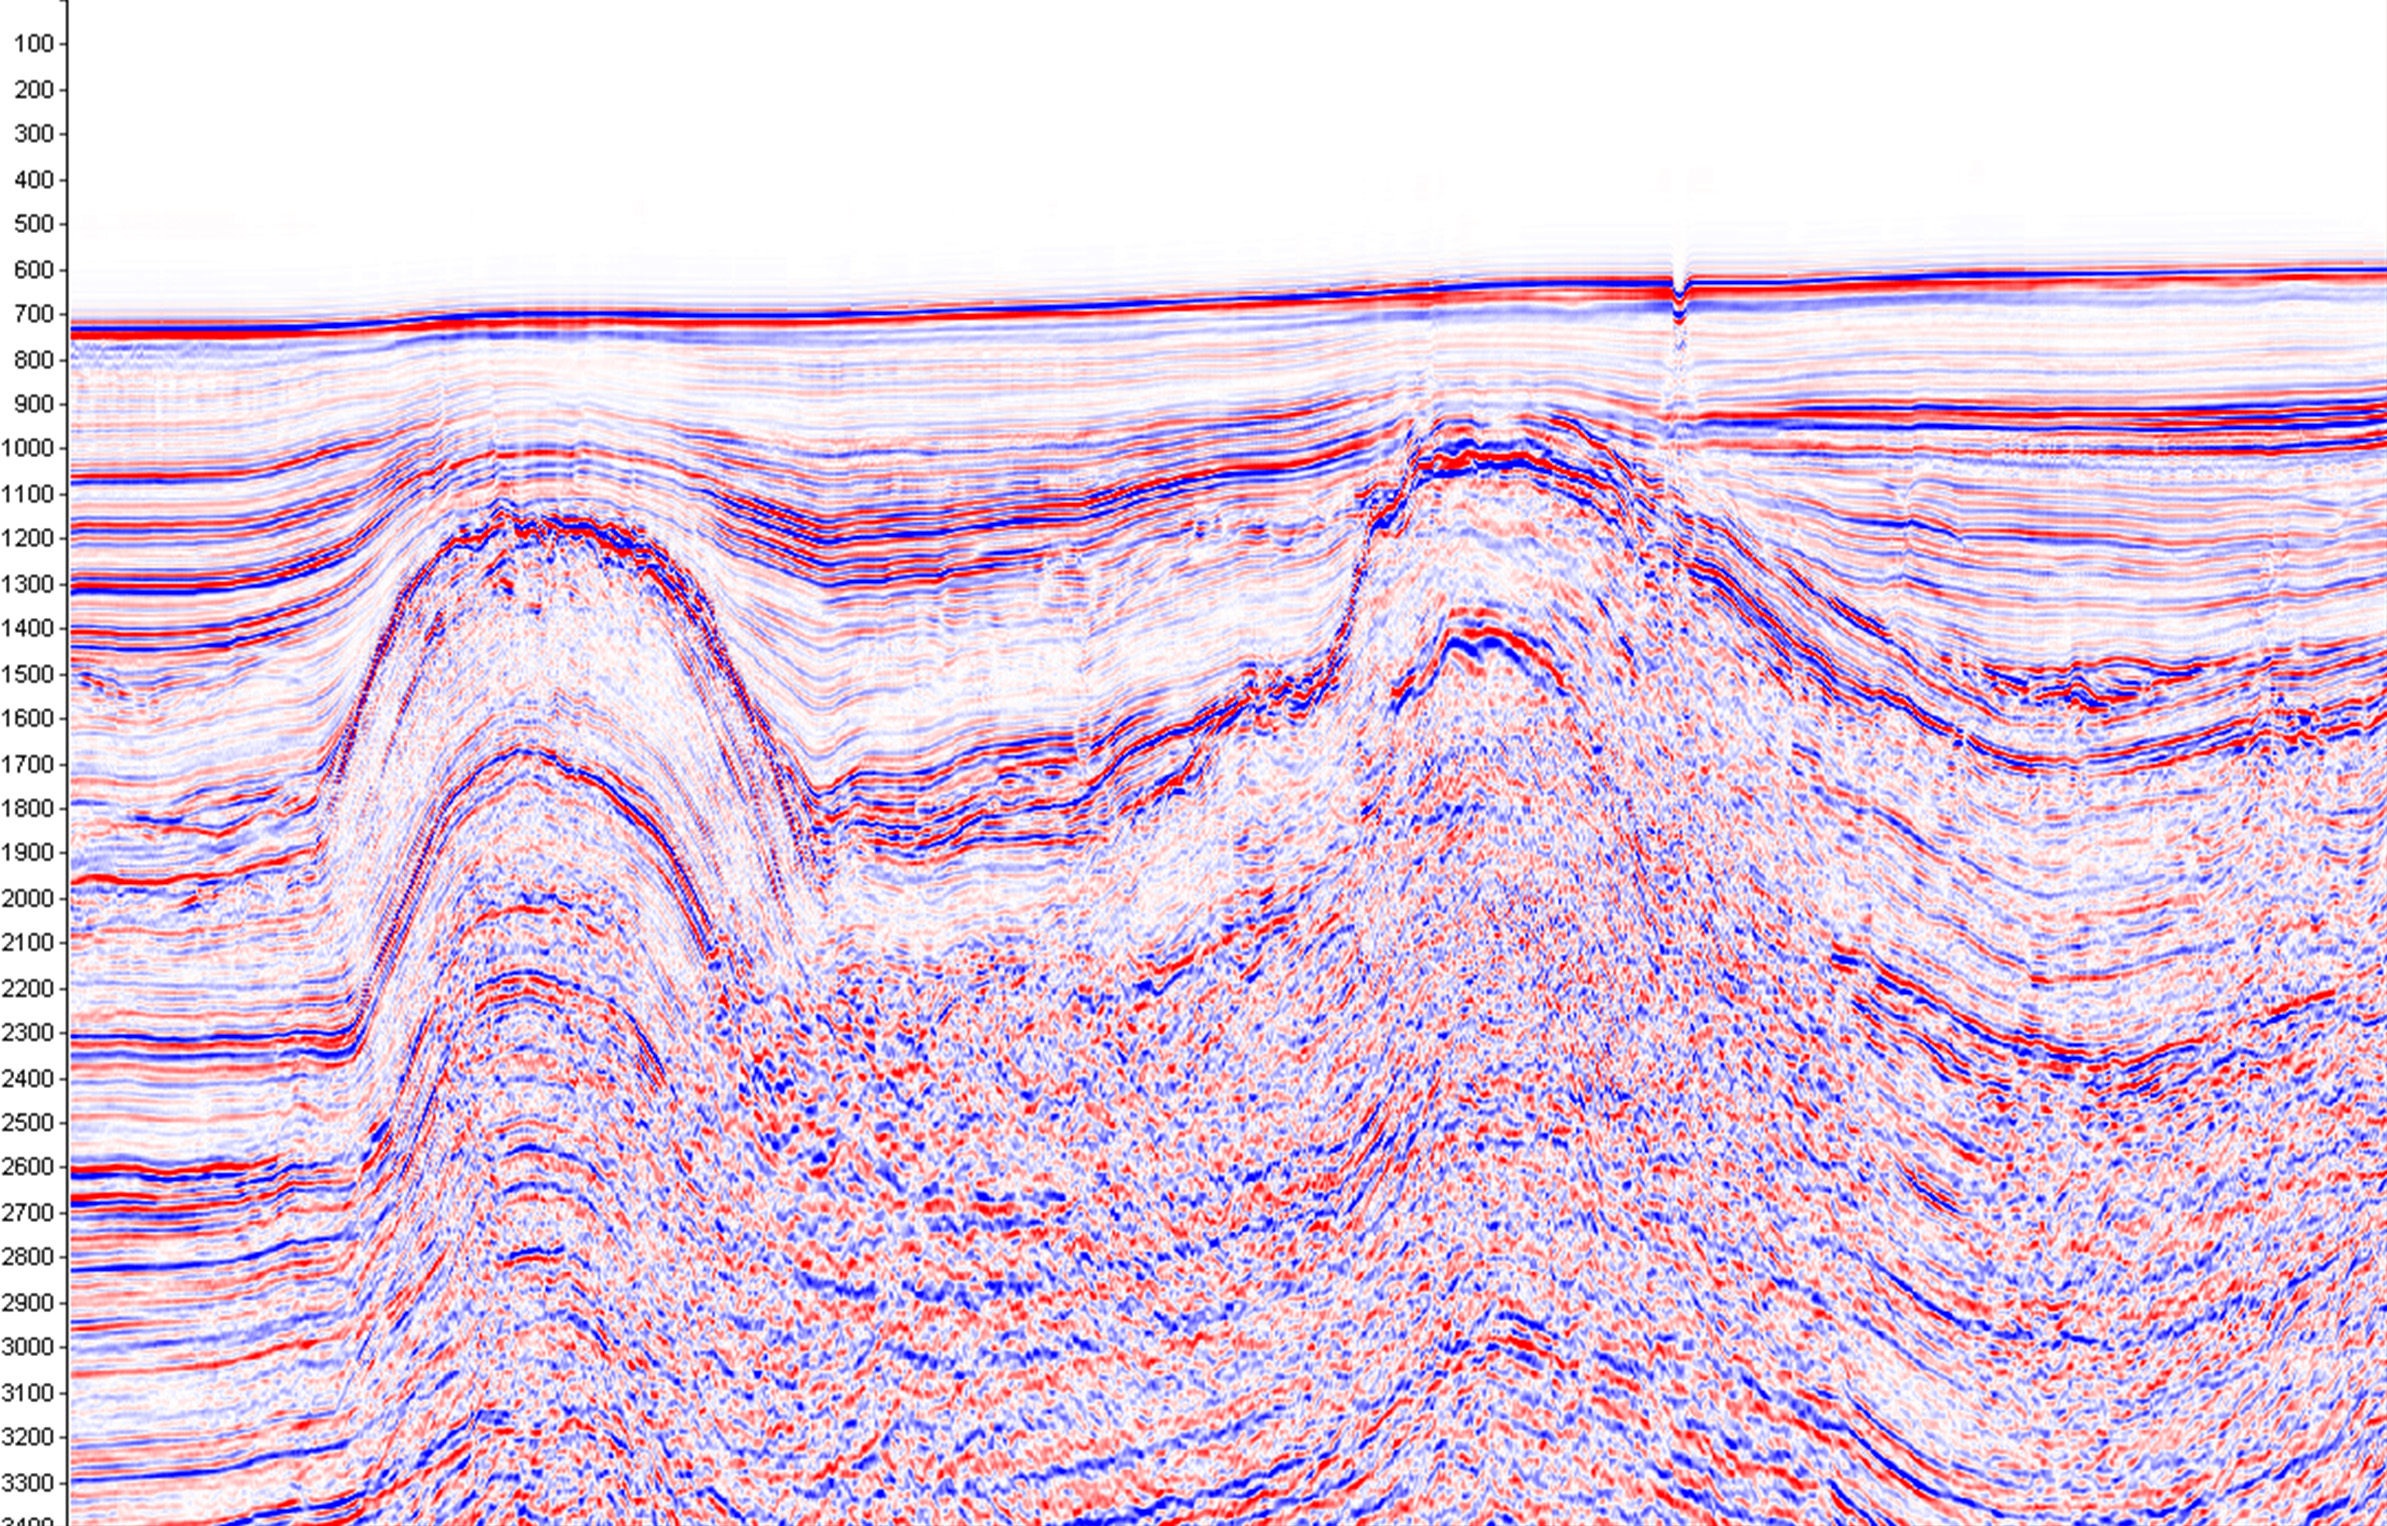

In [14]:
im

In [24]:
width, height = im.size

In [66]:
height = 50

In [67]:
t_min, t_max

(0.0, 3.4)

In [68]:
dts = [0.0005, 0.001, 0.002, 0.004, 0.008]

for dt in sorted(dts, reverse=True):
    target = (t_max - t_min) / dt
    if target > height: break

In [69]:
dt

0.008

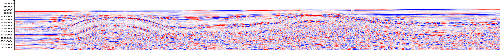

In [72]:
im.resize((500, 50))

In [17]:
# Statistics
fsd, psd = np.nanstd(f_list), np.nanstd(p_list)
fn, pn = len(f_list), len(p_list)

if avg == 'trim' and fn>4:
    f = scipy.stats.trim_mean(f_list, 0.2)
elif avg == 'mean' or (avg=='trim' and fn<=4):
    f = np.nanmean(f_list)
else:
    raise InvalidUsage('avg parameter must be trim or mean', status_code=410)

if avg == 'trim' and pn>4:
    p = scipy.stats.trim_mean(p_list, 0.2)
elif avg == 'mean' or (avg=='trim' and pn<=4):
    p = np.nanmean(p_list)
else:
    raise InvalidUsage('avg parameter must be trim or mean', status_code=410)

snrsd = np.nanstd(snr_list)
snr = np.nanmean(snr_list)

# Spectrum
spec = np.mean(np.dstack(specs), axis=-1)
fs = i.shape[0] / (t_max - t_min)
freq = np.fft.rfftfreq(i.shape[0], 1/fs)
f_min = np.amin(mis)
f_max = np.amax(mas)

# Histogram
if bins:
    hist = np.histogram(i, bins=bins)
else:
    hist = None

ValueError: need at least one array to concatenate

## Result

In [10]:
import json

result = {'job_uuid': uuid_str}

result['result'] = {}
result['result']['freq'] = {'peak': np.round(f, 2),
                            'sd': np.round(fsd, 2),
                            'n': fn,
                            'min': np.round(f_min, 2),
                            'max': np.round(f_max, 2)}

result['result']['phase'] = {'avg': np.round(p, 2),
                             'sd': np.round(psd, 2),
                             'n': pn}

result['result']['snr'] = {'avg': np.round(snr, 2),
                           'sd': np.round(snrsd, 2)}

result['result']['greyscale'] = grey
result['result']['img_size'] = {'height': im.size[0], 'width': im.size[1]}

if spectrum:
    result['result']['spectrum'] = {'coefficients': spec.tolist(),
                                    'frequencies': freq.tolist()}

if hist:
    result['result']['histogram'] = {'counts': hist[0].tolist(),
                                     'bins':  hist[1].tolist()}

result['parameters'] = {'method': method}
result['parameters']['avg'] = avg
result['parameters']['time_range'] = [t_min, t_max]
result['parameters']['region'] = region
result['parameters']['trace_spacing'] = trace_spacing
result['parameters']['traces'] = traces.tolist()
result['parameters']['url'] = url

json.dumps(result)

'{"job_uuid": "87710757-525a-11e5-b533-a820663a5ca4", "parameters": {"url": "https://math.berkeley.edu/~sethian/2006/Applications/Seismic/time_mig_img.jpg", "region": "199,141,1608,1087", "time_range": [0.0, 3.0], "trace_spacing": "random", "avg": "mean", "traces": [258, 393, 480, 533, 668, 685, 829, 1147, 1154, 1158], "method": "xing"}, "result": {"img_size": {"width": 946, "height": 1409}, "histogram": {"counts": [147554, 166745, 248210, 325383, 155390, 89887, 69430, 54897, 75418], "bins": [-128.0, -99.66666666666667, -71.33333333333334, -43.0, -14.666666666666671, 13.666666666666657, 42.0, 70.33333333333331, 98.66666666666666, 127.0]}, "greyscale": true, "snr": {"avg": 0.47999999999999998, "sd": 0.02}, "phase": {"n": 10, "avg": 0.90000000000000002, "sd": 32.890000000000001}, "freq": {"min": 0.83999999999999997, "max": 157.30000000000001, "n": 10, "peak": 20.210000000000001, "sd": 0.80000000000000004}}}'